### Purpose
The purpose of this code is to reproduce the response of a superconducting quantum interference device (SQUID) by numerical simulation. We will numerical method, namely Runge-Kutta 4th order fixed-time step modified to accept a noise signal, to simulate the average voltage response of a pair of resistively shunted Josephson junctions in parrallel, with Johnson noise in the shunt. We wish to make the model dependent on physical parameters of the circuit (critical current and symmetry considerations in shunt resistance and branch inductances) and dependent on input parameters as the applied flux and bias current placed across the circuit. This model will be useful in basic investigation of circuit behavior and in fitting physical parameters to real circuits.
![training_VPhi_3D.jpg](training_VPhi_3D.jpg)

### The Model
The model used here is from Tesche-Clarke 1977, section 2. The model is developed by combining the Josephson effects of two resistively shunted Josephson junctions arranged on a superconductiong ring. The junctions are in parrallel with respect to the bias current and voltage across the circuit.
![squid_circuit.jpg](squid_circuit.jpg)
Having combined effects and converte to dimensionless units, the needed system of equations is found to be:

$$j = (\delta_1 - \delta_2 - 2\pi\phi_a)/\pi \beta{}_L - \eta i /2$$

$$v = \frac{1+\eta}{2}\frac{d\delta_1}{d\theta} + \frac{1-\eta}{2}\frac{d\delta_2}{d\theta}$$

$$\frac{d\delta_1}{d\theta} = \frac{i/2 - j-(1-\alpha)\sin{\delta_1}}{1-\rho} + v_{N1}$$

$$\frac{d\delta_2}{d\theta} = \frac{i/2 - j-(1+\alpha)\sin{\delta_2}}{1+\rho} + v_{N2}$$

#### Parameters

$I_0$ - critical current of each junction

$\Phi_0$ - flux quantum

$R$ - total resistance of circuit (shunts)

$\theta$ - dimensionless time [$\Phi_0/2\pi I_0 R$]

$j$ - circulating current in superconducting ring [$I_0$]

$\delta_{1,2}$ - phase difference across each junction

$\phi_a$ - applied flux [$\Phi_0$]

$\eta$ - inductance symmetry parameter (0 to 1)

$v$ - voltage across circuit [$I_0 R$]

$i$ - applied bias current [$I_0$]

$\alpha$ - critical current symmetry parameter (0 to 1)

$\rho$ - resistance symmetry parameter (0 to 1)

$\beta_L$ - inductance constant

$v_{N1,2}$ - noise signal, random Gaussian distributed voltage value [$I_0 R$]

This model considers the Johnson noise in the resistive shunts. This effect is temperature dependent and can be described by the parameter $\Gamma$, which is temperature dependent. The value will be supplied by the user for our model rather than derived. The random, Gaussian distributed voltage noise values have average value 0 and standard deviation* $\sigma_{v_N}=\sqrt{2\Gamma/\Delta\theta}$. (more on this in the numrical method section)

### Numerical Method
#### Modified Runge-Kutta 4th order, fixed-time step

We will use a modified RK4 fixed-time step method to solve the time series voltage output for the system. The fixed step size is chosen to simplify the modification of the method to utilize the noise signals, $v_{N1,2}$. The RK4 method will use half-time steps, meaning the method will calculate values at the current moment, halfway to the next time output, and at the next time point to output the value at the next time point. At the first iteration, the method will use $t_0, t_{1/2}, t_1$ to output $v_1$. Then, it will use $t_1, t_{3/2}, t_2$ to output $v_2$. Then we need to keep track of and pass noise values $v_n$ such that the RK4 method has available $v_0, v_1, v_2$ at $t_0$ to return $v_1$ and then pass $v_2, v_3, v_4$ at $t_1$ to return $v_2$, and so on.

Because we are creating and using twice as many noise values as voltage outputs, we need to modify the standard deviation quoted above in the model section. Since each noise value occurs at a half time step, we have

$$\sigma_{v_N} = \sqrt{\frac{2\Gamma}{\frac{\Delta \theta}{2}} }=\sqrt{ \frac{4\Gamma}{\Delta \theta}}$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.fft as fft
import scipy.signal as sig
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from scipy import interpolate
import csv
import datetime

The code immediately below is a progress bar for routines that take a while.

In [2]:
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

#### Modified RK4
Here we employ a standard RK4 method modified to pass noise values to the derivative function at each iteration. We need to pass three noise values for each junction at each iteration, namely the present time noise values, the values at a half-time step away, and the values at a full time step away. We have to supply the correct values at each iteration, meaning the last pair of noise values passed for the present iteration must also be the first set of noise values passed at the next iteration. We simply define those as supplied parameters to the solver, and let them drop through to the derivative functions as appropriate.

For the purposes of this notebook, I have left all input parameters as scalars rather than combine them as vectors where it may be more concise.

In [13]:
def noisyRK4(s,th,tau,derivsRK,par,vn10,vn20,vn11,vn21,vn12,vn22):
    """RK4 integrator modified to use noise
    INPUTS
        s - state vector
        th - time, theta
        tau - time step size
        derivsRK - RHS of ODE, fn defined somewhere
        par - array
            [alpha,betaL,eta,rho,i,phia,Gamma]
    OUTPUTS
        sout - new state vector new time
            [delta_1,delta_2,ddelta_1,ddelta_2]"""
    
    # parse out parameter array
    alpha = par[0]; betaL = par[1]; eta = par[2]
    rho = par[3]; i = par[4]; phia = par[5]; Gamma=par[6]
    
    # noisySQUIDrk(s,th,alpha,beta,eta,rho,i,phia,vn1,vn2)
    
    half_tau = 0.5*tau
    
    F1 = derivsRK(s,th,par,vn10,vn20)             # use current voltage noise
    th_half = th + half_tau
    stemp = s + half_tau*F1
    
    F2 = derivsRK(stemp,th_half,par,vn11,vn21)    # use half-tau step voltage noise
    stemp = s + half_tau*F2
    
    F3 = derivsRK(stemp,th_half,par,vn11,vn21)    # use half-tau step voltage noise
    th_full = th + tau
    stemp = s + tau*F3
    
    F4 = derivsRK(stemp,th_full,par,vn12,vn22)    # use full-tau step voltage noise
    sout = s + tau/6.*(F1 + F4 + 2.*(F2 + F3))
    return sout 

The function below is called by the modified RK4 above. It returns the calculated value of the derivative at a half-time step away or a full time step away as requested by the RK4. Noise values fall through from the RK4 to the function below.

In [15]:
def noisySQUIDrk(s,th,par,vn1,vn2):
    """Returns derivatives of the SQUID system
    DEPENDENCIES
        numpy as np
    INPUTS
        s - state vector, [delta_1, delta_2]
        th - dimensioless time
        par - array
            [alpha,betaL,eta,rho,i,phia,Gamma,betaC,kappa]
        alpha - critical current symmetry parameter (0 to 1)
        beta - inductance constant
        eta - inductance symmetry parameter (0 to 1)
        rho - resistance symmetry parameter (0 to 1)
        i - dimensionless bias current
        phia - dimensionless applied flux
        vn1 - voltage noise value at junction 1
        vn2 - voltage noise value at junction 2
    OUTPUTS
        deriv - array of derivs, [ddelta_1/dth, ddelta_2/dth]"""

    # parse out parameter array
    alpha = par[0]; betaL = par[1]; eta = par[2]
    rho = par[3]; i = par[4]; phia = par[5]; Gamma=par[6]
    
    # calculate the present circ. current for use below
    j = (s[0] - s[1] - 2*np.pi*phia)/(np.pi*betaL) - eta*i/2
    
    # calculate the present value of the time derivatives of phases
    d1 = (.5*i-j-(1-alpha)*np.sin(s[0]))/(1-rho) + vn1 # ddel1/dth
    d2 = (.5*i+j-(1+alpha)*np.sin(s[1]))/(1+rho) + vn2 # ddel2/dth
    
    deriv = np.array([d1,d2])
    return(deriv)

We need a function to handle the solver. We need the handler to accept simulation parameters (number of steps, step size, initial conditions, physical parameters), create a set of noise values, create a data structure and populate with initial conditions. Then call the RK4 solver within a loop and store the output in an array which will be returned to the user.

In [17]:
def noisySQUID(nStep,tau,s,par):
    """Returns array of simulated output data for SQUID
    DEPENDENCIES
        numpy as np
        noisyRK - RK4 solver modified to use noise
    INPUTS
        nStep - number of time steps for which to give output
        tau - time step size
        s - starting state vector, [delta_1,delta_2]
        par - array
            [alpha,betaL,eta,rho,i,phia,Gamma,betaC,kappa]
            alpha - critical current symmetry parameter (0 to 1)
            beta - inductance constant
            eta - inductance symmetry parameter (0 to 1)
            rho - resistance symmetry parameter (0 to 1)
            i - dimensionless bias current
            phia - dimensionless applied flux
            Gamma - Johnson noise parameter
    OUTPUT
        X - output array [[delta_1],[delta_2],[j],[v_1],[v_2],[v]]"""
    #parse out the param vector
    alpha=par[0]; betaL=par[1]; eta=par[2]; rho=par[3]
    i=par[4]; phia=par[5]; Gamma=par[6]
    
    ## NOISE ##
    # set an appropriate variance based on Gamma.
    # variance is twice normal because freq of noise
    # is twice that of the sampling freq so that rk4 has
    # a noise value to use at each half tau step
    var = 4*Gamma/tau
    sd = var**.5
    
    # make two time series of noise voltages
    vn1 = np.zeros(2*nStep+1)
    vn2 = np.zeros(2*nStep+1)
    for ist in range(2*nStep+1):
        vn1[ist] = np.random.normal(0,sd)
        vn2[ist] = np.random.normal(0,sd)
    
    ## DATA STRUCTIRE, X[0:6,0:nStep*tau:tau] ##
    # going to keep: theta, d1, d2, j, ddelta_1/dth, ddelta_2/dth, v
    # X[0,:] = theta
    # X[1,:], X[2,:] = delta_1, delta_2 = s[0], s[1]
    # X[3,:] = j = (del10 - del20 - 2*np.pi*phia)/(np.pi*beta) - eta*i/2
    # X[4,:], X[5,:]  = ddelta_1/dtheta, ddelta_2/dtheta
    # = (i/2 -+ j0 -(1 -+ alpha)*np.sin(del10))/(1 -+ rho)
    # X[6,:] = v = (1+eta)*d10/2 + (1-eta)*d20/2
    
    th = 0
    X = np.zeros([7,nStep])
    # set initial conditions
    X[1,0] = s[0]
    X[2,0] = s[1]
    X[3,0] = (s[0] - s[1] - 2*np.pi*phia)/(np.pi*betaL) - eta*i/2
    X[4,0] = (i/2 - X[3,0] -(1-alpha)*np.sin(s[0]))/(1-rho)
    X[5,0] = (i/2 + X[3,0] -(1+alpha)*np.sin(s[1]))/(1+rho)
    X[6,0] = (1+eta)*X[4,0]/2 + (1-eta)*X[5,0]/2
    
    ## For loop ##
    # Grab the appropriate voltage noise values to pass to rk4 solver;
    #     Each rk4 call needs the noise voltage now, at now+tau/2, and
    #     at now+tau.
    # Update state variable s[0:1] = <delta_1,delta_2> by calling the
    # noisyRK4() to get state values at next time step, now+tau
    # Update the data structure
    # Finally, update time theta to now+tau
    
    for iStep in range(1,nStep):
        vn10 = vn1[2*iStep-2]
        vn20 = vn2[2*iStep-2]
        vn11 = vn1[2*iStep-1]
        vn21 = vn2[2*iStep-1]
        vn12 = vn1[2*iStep]
        vn22 = vn2[2*iStep]
        
        #   noisyRK4(s,th,alpha,beta,eta,rho,i,phia,tau,derivsRK,vn10,vn20,vn11,vn21,vn12,vn22)
        s = noisyRK4(s,th,tau,noisySQUIDrk,par,vn10,vn20,vn11,vn21,vn12,vn22)
        
        X[0,iStep] = th
        X[1,iStep] = s[0]
        X[2,iStep] = s[1]
        X[3,iStep] = (s[0] - s[1] - 2*np.pi*phia)/(np.pi*betaL) - eta*i/2
        X[4,iStep] = (i/2 - X[3,iStep] - (1-alpha)*np.sin(s[0]))/(1-rho)
        X[5,iStep] = (i/2 + X[3,iStep] - (1+alpha)*np.sin(s[1]))/(1+rho)
        X[6,iStep] = (1+eta)*X[4,iStep]/2 + (1-eta)*X[5,iStep]/2
        
        th = th + tau        
    return(X)    

We can test the basic function of the handler by using it to create a simple time series output for a fixed bias current and applied flux. We will specify the parameters needed explicitly and then include them as arguments in a call to the handler function. We then look at a simple plot of the time series voltage across the SQUID.

In [29]:
# noisySQUID(nStep,tau,s,alpha,beta,eta,rho,i,phia,Gamma)
nStep = 8000
tau = 0.1
s = np.array([0.,0.])
alpha = 0.
betaL = 1.
eta = 0.
rho = 0.
i = 1.5
phia = 0.5
Gamma = 0.05
par=np.array([alpha,betaL,eta,rho,i,phia,Gamma])

In [30]:
# noisySQUID(nStep,tau,s,alpha,beta,eta,rho,i,phia,Gamma)
SQ = noisySQUID(nStep,tau,s,par)

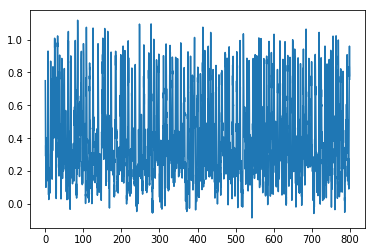

In [31]:
plt.plot(SQ[0,],SQ[6,])

Below is a routine for creating an average voltage and circulating current timeseries plot and to output a csv with the timeseries results of the simulation.

In [6]:
def vj_timeseries(nStep,tau,s,par):
    """Returns time series simulation of squid, figure and csv
    DEPENDENCIES
    qSQUID()
        numpy as np
        matplotlib.pyplot as plt
    INPUTS
        nStep - number of steps to run in time series
        tau - step size for time series
        s - initial state vector [delta_1[theta=0],delta_2[theta=0]]
        par - parameter vector
            [alpha,betaL,eta,rho,i,phia,Gamma,betaC,kappa]
    OUTPUTS
        figure - plots of
            voltage time series w average
            circulating current time series w average
            output to screen
            png 'timeseriesdatetime.png' saved to parent directory
        csv - time series csv file containing
            theta,delta_1,delta_2,j,ddel1/dth,ddel2/dth,v
            csv 'timeseriesdatetime.csv' saved to parent directory            
        """
    # run sim
    S = noisySQUID(nStep,tau,s,par)
    # chop off first 10% of time series to remove any transient
    md = int(.1*len(S[0,:]))
    
    # build figure title with parameters used
    ti = r'$\alpha$=%s, $\beta_L$=%s, $\eta$=%s'% (str(round(par[0],3)),str(round(par[1],3)),str(round(par[2],3)))+'\n'+\
            r'$\rho$=%s, $i$=%s, $\phi_a$=%s' % (str(round(par[3],3)),str(round(par[4],3)),str(round(par[5],3)))+'\n'+\
            r'$\Gamma$=%s' %(str(round(par[6],3)))
            
    # plot
    fig, ax = plt.subplots(2,1,figsize=(3,7))
    fig.suptitle(ti)
    ax1 = plt.subplot(2,1,1)
    ax1.plot(S[0,md:],S[6,md:])
    ax1.hlines((sum(S[6,md:])/len(S[6,md:])),S[0,md],S[0,-1],linestyle='dotted')
    ax1.set(ylabel="Voltage, v",
       xticklabels=([]))
    ax2 = plt.subplot(2,1,2)
    ax2.plot(S[0,md:],S[3,md:])
    ax2.hlines((sum(S[3,md:])/len(S[3,md:])),S[0,md],S[0,-1],linestyle='dotted')
    ax2.set(ylabel="Circ Current, j",
       xlabel=r"Time,$\theta$")
    
    # create output file metadata    
    meta1 = ['# alpha=%s'%par[0],'betaL=%s'%par[1],'eta=%s'%par[2],'rho=%s'%par[3],'i=%s'%par[4],'phia=%s'%par[5]]
    meta2 = ['# nStep=%s'%nStep,'tau=%s'%tau]
    header = ['theta','delta_1','delta_2','j','ddel1/dth','ddel2/dth','v']
    csvtime = datetime.datetime.now()
    timestr = [datetime.datetime.strftime(csvtime, '# %Y/%m/%d, %H:%M:%S')]
    timeti = str(datetime.datetime.strftime(csvtime, '%Y%m%d%H%M%S'))
    csvtitle='timeseries'+timeti+'.csv'
    pngtitle='timeseris'+timeti+'.png'
    Sf = np.matrix.transpose(S)
    
    # create, write, output(close) csv file
    with open(csvtitle, 'w') as csvFile:
        filewr = csv.writer(csvFile,delimiter=',')
        filewr.writerow(timestr)
        filewr.writerow(meta1)
        filewr.writerow(meta2)
        filewr.writerow(header)
        filewr.writerows(Sf)
    csvFile.close()
    # save figure
    fig.savefig(pngtitle)
    print('csv file written out:', csvtitle)
    print('png file written out:', pngtitle)

csv file written out: timeseries20191129171129.csv
png file written out: timeseris20191129171129.png


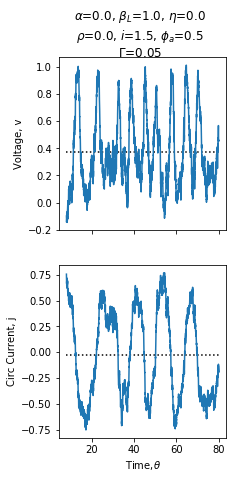

In [36]:
nStep = 8000
tau = 0.01
s = np.array([1.,0.])
alpha = 0.
betaL = 1.
eta = 0.
rho = 0.
i = 1.5
phia = 0.5
Gamma = 0.05

par = np.array([alpha,betaL,eta,rho,i,phia,Gamma])

vj_timeseries(nStep,tau,s,par)

Some code to build VPhi and IV curves would be useful. We can specify that we want contours as functions of one of the parameters by specifying those parameters as a list.

In [7]:
def iv_curve(nStep,tau,s,par,alpha=0,betaL=0,eta=0,rho=0,phia=0,Gamma=0):
    """Returns contour plot and data file for IV curves
    DEPENDENCIES
        qSQUID()
        update_progress()
        numpy as np
        matplotlib.pyplot as plt
    INPUTS
        nStep - number of steps to run in time series
        tau - step size for time series
        s - initial state vector [delta_1[theta=0],delta_2[theta=0]]
        par - parameter vector
            [alpha, beta_L, eta, rho, i, phia]
        input parameter LIST - alpha, beta, eta, rho, phia
            multiple values of input parameter as list
            draws contour for each
            if given, overwrites value in par
            if not given, value from par is used for one contour
            ONLY SUPPLY maximum of one input list here
    OUTPUTS
        plot - IV contours at levels given in input param array
            output to screen
            png 'IVdatetime.png' saved to parent directory
        csv - IV contours at levels given
            csv 'IVdatetime.png' saved to parent directory
        """
    # create currents to sweep
    i = np.arange(0.,6.,.1)
    
    ch = 0 # check for only one parameter sweeped.
    k = 1 # set 0 axis dim to 1 at min
    md = int(0.1*len(i)) # cut of the first 10 percent of points in time series
    
    # check if an array was given for an input parameter
    # k - length of input parameter array (number of contours)
    # parj - build a list of parameters to pass at each array value of that parameter
    # la, lc - plot label and csv header lable
    # lb - rename parameter array to add in plot and header later
    # ti - plot title
    # meta1 - csv metadata
    # ch - check value, check for only one input parameter array, or none for one contour
    if alpha != 0:
        alpha = np.array(alpha)
        k = len(alpha)
        parj = np.zeros([k,7])
        la = r'$\alpha$'; lc = 'alpha'
        lb = np.copy(alpha)
        ti = r'$\beta_L$=%s, $\eta$=%s, $\rho$=%s, $\phi_a$=%s' % (str(round(par[1],3)),str(round(par[2],3)),str(round(par[3],3)),str(round(par[5],3)))+'\n'+\
                r'$\Gamma$=%s' %(str(round(par[6],3)))
        meta1 = ['betaL=%s'%par[1],'eta=%s'%par[2],'rho=%s'%par[3],'i=%s'%par[4],'phia=%s'%par[5],'Gamma=%s'%par[6]]
        # add input array values to iteration parameters as appropriate
        for j in range(k):
            parj[j,:] = np.array([alpha[j],par[1],par[2],par[3],0.,par[5],par[6]])
        ch = ch + 1
    if betaL != 0:
        betaL = np.array(betaL)
        k = len(betaL)
        parj = np.zeros([k,7])
        la = r'$\beta_L$'; lc = 'betaL'
        lb = np.copy(betaL)
        ti = r'$\alpha$=%s, $\eta$=%s, $\rho$=%s, $\phi_a$=%s' % (str(round(par[0],3)),str(round(par[2],3)),str(round(par[3],3)),str(round(par[5],3)))+'\n'+\
                r'$\Gamma$=%s' %(str(round(par[6],3)))
        meta1 = ['# alpha=%s'%par[0],'eta=%s'%par[2],'rho=%s'%par[3],'i=%s'%par[4],'phia=%s'%par[5],'Gamma=%s'%par[6]]
        for j in range(k):
            parj[j,:] = np.array([par[0],betaL[j],par[2],par[3],0.,par[5],par[6]])
        ch = ch + 1
    if eta != 0:
        eta = np.array(eta)
        k = len(eta)
        parj = np.zeros([k,7])
        la = r'$\eta$'; lc = 'eta'
        lb = np.copy(eta)
        ti = r'$\alpha$=%s, $\beta_L$=%s, $\rho$=%s, $\phi_a$=%s' % (str(round(par[0],3)),str(round(par[1],3)),str(round(par[3],3)),str(round(par[5],3)))+'\n'+\
                r'$\Gamma$=%s' %(str(round(par[6],3)))
        meta1 = ['# alpha=%s'%par[0],'betaL=%s'%par[2],'rho=%s'%par[3],'i=%s'%par[4],'phia=%s'%par[5],'Gamma=%s'%par[6]]
        for j in range(k):
            parj[j,:] = np.array([par[0],par[1],eta[j],par[3],0.,par[5],par[6]])
        ch = ch + 1
    if rho != 0:
        rho = np.array(rho)
        k = len(rho)
        parj = np.zeros([k,7])
        la = r'$\rho$'; lc = 'rho'
        lb = np.copy(phia)
        ti = r'$\alpha$=%s, $\beta_L$=%s, $\eta$=%s, $\phi_a$=%s' % (str(round(par[0],3)),str(round(par[1],3)),str(round(par[2],3)),str(round(par[5],3)))+'\n'+\
                r'$\Gamma$=%s' %(str(round(par[6],3)))
        meta1 = ['# alpha=%s'%par[0],'betaL=%s'%par[1],'eta=%s'%par[2],'i=%s'%par[4],'phia=%s'%par[5],'Gamma=%s'%par[6]]
        for j in range(k):
            parj[j,:] = np.array([par[0],par[1],par[2],rho[j],0.,par[5],par[6]])
        ch = ch + 1
    if phia != 0:
        phia = np.array(phia)
        k = len(phia)
        parj = np.zeros([k,7])
        la = r'$\phi_a$'; lc = 'phi_a'
        lb = np.copy(phia)
        ti = r'$\alpha$=%s, $\beta_L$=%s, $\eta$=%s, $\rho$=%s' % (str(round(par[0],3)),str(round(par[1],3)),str(round(par[2],3)),str(round(par[3],3)))+'\n'+\
                r'$\Gamma$=%s' %(str(round(par[6],3)))
        meta1 = ['# alpha=%s'%par[0],'betaL=%s'%par[1],'eta=%s'%par[2],'rho=%s'%par[3],'i=%s'%par[4],'Gamma=%s'%par[6]]
        for j in range(k):
            parj[j,:] = np.array([par[0],par[1],par[2],par[3],0.,phia[j],par[6]])
        ch = ch + 1
    if Gamma != 0:
        Gamma = np.array(Gamma)
        k = len(Gamma)
        parj = np.zeros([k,7])
        la = r'$\Gamma$'; lc = 'Gamma'
        lb = np.copy(Gamma)
        ti = r'$\alpha$=%s, $\beta_L$=%s, $\eta$=%s, $\rho$=%s, $\phi_a$=%s' % (par[0],par[1],par[2],par[3],par[5])                
        meta1 = ['# alpha=%s'%par[0],'betaL=%s'%par[1],'eta=%s'%par[2],'rho=%s'%par[3],'i=%s'%par[4],'phia=%s'%par[5]]
        for j in range(k):
            parj[j,:] = np.array([par[0],par[1],par[2],par[3],0.,par[5],Gamma[j]])
        ch = ch + 1
    
    # if check value is more than one, too many input parameter arrays given
    if ch > 1:
        return('Please supply at most one parameter to sweep')
    # if check value zero, assume plotting only one contour
    if ch == 0:
        parj = np.zeros([2,7])
        parj[0,:] = par
        parj[1,:] = par
        ti = r'$\alpha$=%s, $\beta_L$=%s, $\eta$=%s, $\rho$=%s' % (str(round(par[0],3)),str(round(par[1],3)),str(round(par[2],3)),str(round(par[3],3)))+ '\n' +\
                r'$\phi_a$=$s, $\Gamma$=%s' % (str(round(par[5],3)),str(round(par[6],3)))
        meta1 = ['# alpha=%s'%par[0],'betaL=%s'%par[1],'eta=%s'%par[2],'rho=%s'%par[3],'phia=%s'%par[5],'Gamma=%s'%par[6]]
    # build sim output array of appropriate size
    # needs as many rows as contours determined by input parameter array
    if k > 1:
        V = np.zeros([k,len(i)])
    else:
        V = np.zeros([2,len(i)])
        
    # cp - check progress, total outputs in V
    cp = k*len(i)
    
    # loop over k rows and len(i) colums of V
    # fill V with average voltage from time series for given params
    # parjj - parameter array for this time series
    # S - state array output from sim
    for j in range(k):
        parjj = parj[j,:]
        for m in range(len(i)):
            parjj[4] = i[m]
            S = noisySQUID(nStep,tau,s,parjj)
            V[j,m] = sum(S[6,md:])/len(S[6,md:])
            # new progress bar current iter/total iters
            update_progress((m + j*len(i))/cp)
    # fill out progress bar
    update_progress(1)
    
    # build output for csv
    # join i values and average Voltage matrix
    Sf = np.concatenate((np.matrix(i),V),axis=0)
    # flip independent axis, i, from horizontal to vertical
    Sf = np.matrix.transpose(Sf)
    # convert from matrix to array to ease csv output
    Sf = np.array(Sf)
    
    # make a figure
    # header - csv header info, param input value for contour
    fig,ax = plt.subplots()
    # one contour, or
    if k == 1:
        ax.plot(V[0],i)
        header = ['i','V']
    # k contours
    else:
        header = ['i']*(k+1)
        for j in range(k):
            ax.plot(V[j],i,label= la + '=%s' % str(round(lb[j],3)))
            header[j+1] = lc + '=%s' % str(round(lb[j],3))
    # ic = 0 line for comparison
    ax.plot(np.arange(0,2.6,.1),np.arange(0,5.2,.2),'--',
       label=r"$i_c=0$")
    ax.set(title=ti,
       xlabel=r"Average voltage, $\bar{v}$",
       ylabel="Bias current, i",
       xlim=[0,2.5],ylim=[0,6.])
    ax.legend()
    fig.tight_layout()
    
    # build rest of metadata needed for csv
    meta2 = ['# nStep=%s'%nStep,'tau=%s'%tau]
    csvtime = datetime.datetime.now()
    timestr = [datetime.datetime.strftime(csvtime, '# %Y/%m/%d, %H:%M:%S')]
    timeti = str(datetime.datetime.strftime(csvtime, '%Y%m%d%H%M%S'))
    csvtitle='IV'+timeti+'.csv'
    pngtitle='IV'+timeti+'.png'
    
    # create, write, and save(close) csv
    with open(csvtitle, 'w') as csvFile:
        filewr = csv.writer(csvFile,delimiter=',')
        filewr.writerow(timestr)
        filewr.writerow(meta1)
        filewr.writerow(meta2)
        filewr.writerow(header)
        filewr.writerows(Sf)
    csvFile.close()
    # save figure
    fig.savefig(pngtitle)
    print('csv file written out:', csvtitle)
    print('png file written out:', pngtitle)

Progress: [####################] 100.0%
csv file written out: IV20191129181540.csv
png file written out: IV20191129181540.png


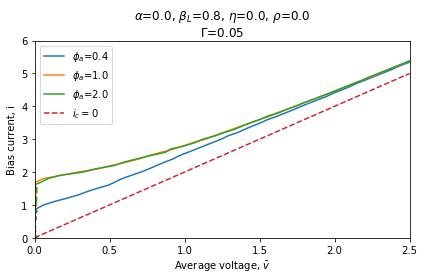

In [51]:
nStep = 8000
tau = 0.1
s = np.array([1.,0.])
alpha = 0.
betaL = 0.8

eta = 0.
rho = 0.
i = 2.1
phia = 0.5
Gamma = 0.05

Phi = [.4,1.,2.]

par = np.array([alpha,betaL,eta,rho,i,phia,Gamma])

iv_curve(nStep,tau,s,par,phia=Phi)

In [8]:
def vphi_curve(nStep,tau,s,par,alpha=0,betaL=0,eta=0,rho=0,i=0,Gamma=0):
    """Returns contour plot and data file for IV curves
    DEPENDENCIES
        qSQUID()
        update_progress()
        numpy as np
        matplotlib.pyplot as plt
    INPUTS
        nStep - number of steps to run in time series
        tau - step size for time series
        s - initial state vector [delta_1[theta=0],delta_2[theta=0]]
        par - parameter vector
            [alpha, beta_L, eta, rho, i, phia]
        input parameter LIST - alpha, beta, eta, rho, phia
            multiple values of input parameter as list
            draws contour for each
            if given, overwrites value in par
            if not given, value from par is used for one contour
            ONLY SUPPLY maximum of one input list here
    OUTPUTS
        plot - IV contours at levels given in input param array
            output to screen
            png 'IVdatetime.png' saved to parent directory
        csv - IV contours at levels given
            csv 'IVdatetime.png' saved to parent directory
        """
    # create currents to sweep
    phia = np.arange(0.,1.05,.05)
    
    ch = 0 # check for only one parameter sweeped.
    k = 1 # set 0 axis dim to 1 at min
    md = int(0.1*len(phia)) # cut of the first 10 percent of points in time series
    
    # check if an array was given for an input parameter
    # k - length of input parameter array (number of contours)
    # parj - build a list of parameters to pass at each array value of that parameter
    # la, lc - plot label and csv header lable
    # lb - rename parameter array to add in plot and header later
    # ti - plot title
    # meta1 - csv metadata
    # ch - check value, check for only one input parameter array, or none for one contour
    if alpha != 0:
        alpha = np.array(alpha)
        k = len(alpha)
        parj = np.zeros([k,7])
        la = r'$\alpha$'; lc = 'alpha'
        lb = np.copy(alpha)
        ti = r'$\beta_L$=%s, $\eta$=%s, $\rho$=%s, $\phi_a$=%s' % (str(round(par[1],3)),str(round(par[2],3)),str(round(par[3],3)),str(round(par[5],3)))+'\n'+\
                r'$\Gamma$=%s' %(str(round(par[6],3)))
        meta1 = ['betaL=%s'%par[1],'eta=%s'%par[2],'rho=%s'%par[3],'i=%s'%par[4],'phia=%s'%par[5],'Gamma=%s'%par[6]]
        # add input array values to iteration parameters as appropriate
        for j in range(k):
            parj[j,:] = np.array([alpha[j],par[1],par[2],par[3],par[4],0.,par[6]])
        ch = ch + 1
    if betaL != 0:
        betaL = np.array(betaL)
        k = len(betaL)
        parj = np.zeros([k,7])
        la = r'$\beta_L$'; lc = 'betaL'
        lb = np.copy(betaL)
        ti = r'$\alpha$=%s, $\eta$=%s, $\rho$=%s, $\phi_a$=%s' % (str(round(par[0],3)),str(round(par[2],3)),str(round(par[3],3)),str(round(par[5],3)))+'\n'+\
                r'$\Gamma$=%s' %(str(round(par[6],3)))
        meta1 = ['# alpha=%s'%par[0],'eta=%s'%par[2],'rho=%s'%par[3],'i=%s'%par[4],'phia=%s'%par[5],'Gamma=%s'%par[6]]
        for j in range(k):
            parj[j,:] = np.array([par[0],betaL[j],par[2],par[3],par[4],0.,par[6]])
        ch = ch + 1
    if eta != 0:
        eta = np.array(eta)
        k = len(eta)
        parj = np.zeros([k,7])
        la = r'$\eta$'; lc = 'eta'
        lb = np.copy(eta)
        ti = r'$\alpha$=%s, $\beta_L$=%s, $\rho$=%s, $\phi_a$=%s' % (str(round(par[0],3)),str(round(par[1],3)),str(round(par[3],3)),str(round(par[5],3)))+'\n'+\
                r'$\Gamma$=%s' %(str(round(par[6],3)))
        meta1 = ['# alpha=%s'%par[0],'betaL=%s'%par[2],'rho=%s'%par[3],'i=%s'%par[4],'phia=%s'%par[5],'Gamma=%s'%par[6]]
        for j in range(k):
            parj[j,:] = np.array([par[0],par[1],eta[j],par[3],par[4],0.,par[6]])
        ch = ch + 1
    if rho != 0:
        rho = np.array(rho)
        k = len(rho)
        parj = np.zeros([k,7])
        la = r'$\rho$'; lc = 'rho'
        lb = np.copy(phia)
        ti = r'$\alpha$=%s, $\beta_L$=%s, $\eta$=%s, $\phi_a$=%s' % (str(round(par[0],3)),str(round(par[1],3)),str(round(par[2],3)),str(round(par[5],3)))+'\n'+\
                r'$\Gamma$=%s' %(str(round(par[6],3)))
        meta1 = ['# alpha=%s'%par[0],'betaL=%s'%par[1],'eta=%s'%par[2],'i=%s'%par[4],'phia=%s'%par[5],'Gamma=%s'%par[6]]
        for j in range(k):
            parj[j,:] = np.array([par[0],par[1],par[2],rho[j],par[4],0.,par[6]])
        ch = ch + 1
    if i != 0:
        i = np.array(i)
        k = len(i)
        parj = np.zeros([k,7])
        la = r'$i$'; lc = 'i'
        lb = np.copy(i)
        ti = r'$\alpha$=%s, $\beta_L$=%s, $\eta$=%s, $\rho$=%s' % (str(round(par[0],3)),str(round(par[1],3)),str(round(par[2],3)),str(round(par[3],3)))+'\n'+\
        r'$\Gamma$=%s' %(str(round(par[6],3)))
        meta1 = ['# alpha=%s'%par[0],'betaL=%s'%par[1],'eta=%s'%par[2],'rho=%s'%par[3],'phia=%s'%par[5],'Gamma=%s'%par[6]]
        for j in range(k):
            parj[j,:] = np.array([par[0],par[1],par[2],par[3],i[j],0.,par[6]])
        ch = ch + 1
    if Gamma != 0:
        Gamma = np.array(Gamma)
        k = len(Gamma)
        parj = np.zeros([k,7])
        la = r'$\Gamma$'; lc = 'Gamma'
        lb = np.copy(Gamma)
        ti = r'$\alpha$=%s, $\beta_L$=%s, $\eta$=%s, $\rho$=%s, $\phi_a$=%s' % (par[0],par[1],par[2],par[3],par[5])                
        meta1 = ['# alpha=%s'%par[0],'betaL=%s'%par[1],'eta=%s'%par[2],'rho=%s'%par[3],'i=%s'%par[4],'phia=%s'%par[5]]
        for j in range(k):
            parj[j,:] = np.array([par[0],par[1],par[2],par[3],par[4],0.,Gamma[j]])
        ch = ch + 1
    
    # if check value is more than one, too many input parameter arrays given
    if ch > 1:
        return('Please supply at most one parameter to sweep')
    # if check value zero, assume plotting only one contour
    if ch == 0:
        parj = np.zeros([2,6])
        parj[0,:] = par
        parj[1,:] = par
        ti = r'$\alpha$=%s, $\beta_L$=%s, $\eta$=%s, $\rho$=%s' % (str(round(par[0],3)),str(round(par[1],3)),str(round(par[2],3)),str(round(par[3],3)))+ '\n' +\
                r'$\phi_a$=%s, $\Gamma$=%s, $\beta_C$=%s, $\kappa$=%s' % (str(round(par[5],3)),str(round(par[6],3)),str(round(par[7],3)),str(round(par[8],3)))
        meta1 = ['# alpha=%s'%par[0],'betaL=%s'%par[1],'eta=%s'%par[2],'rho=%s'%par[3],'i=%s'%par[4],'Gamma=%s'%par[6],'betaC=%s'%par[7],'kappa=%s'%par[8]]
    # build sim output array of appropriate size
    # needs as many rows as contours determined by input parameter array
    if k > 1:
        V = np.zeros([k,len(phia)])
    else:
        V = np.zeros([2,len(phia)])
        
    # cp - check progress, total outputs in V
    cp = k*len(phia)
    
    # loop over k rows and len(i) colums of V
    # fill V with average voltage from time series for given params
    # parjj - parameter array for this time series
    # S - state array output from sim
    for j in range(k):
        parjj = parj[j,:]
        for m in range(len(phia)):
            parjj[5] = phia[m]
            S = noisySQUID(nStep,tau,s,parjj)
            V[j,m] = sum(S[6,md:])/len(S[6,md:])
            # new progress bar current iter/total iters
            update_progress((m + j*len(phia))/cp)
    # fill out progress bar
    update_progress(1)
    
    # build output for csv
    # join i values and average Voltage matrix
    Sf = np.concatenate((np.matrix(phia),V),axis=0)
    # flip independent axis, i, from horizontal to vertical
    Sf = np.matrix.transpose(Sf)
    # convert from matrix to array to ease csv output
    Sf = np.array(Sf)
    
    # make a figure
    # header - csv header info, param input value for contour
    fig,ax = plt.subplots()
    # one contour, or
    if k == 1:
        ax.plot(phia,V[0])
        header = ['phia','V']
    # k contours
    else:
        header = ['phia']*(k+1)
        for j in range(k):
            ax.plot(phia,V[j],label= la + '=%s' % str(round(lb[j],3)))
            header[j+1] = lc + '=%s' % str(round(lb[j],3))
    ax.set(title=ti,
       xlabel=r"Applied flux, $\phi_a$",
       ylabel=r"Average voltage, $\bar{v}$")
    ax.legend()
    fig.tight_layout()
    
    # build rest of metadata needed for csv
    meta2 = ['# nStep=%s'%nStep,'tau=%s'%tau]
    csvtime = datetime.datetime.now()
    timestr = [datetime.datetime.strftime(csvtime, '# %Y/%m/%d, %H:%M:%S')]
    timeti = str(datetime.datetime.strftime(csvtime, '%Y%m%d%H%M%S'))
    csvtitle='VPhi'+timeti+'.csv'
    pngtitle='VPhi'+timeti+'.png'
    
    # create, write, and save(close) csv
    with open(csvtitle, 'w') as csvFile:
        filewr = csv.writer(csvFile,delimiter=',')
        filewr.writerow(timestr)
        filewr.writerow(meta1)
        filewr.writerow(meta2)
        filewr.writerow(header)
        filewr.writerows(Sf)
    csvFile.close()
    # save figure
    fig.savefig(pngtitle)
    print('csv file written out:', csvtitle)
    print('png file written out:', pngtitle)

Progress: [####################] 100.0%
csv file written out: VPhi20191129182743.csv
png file written out: VPhi20191129182743.png


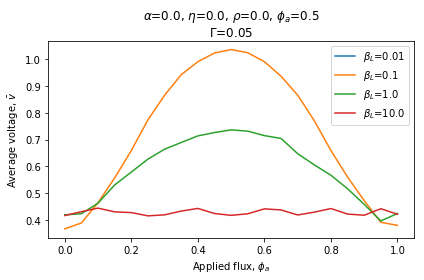

In [55]:
Beta=[.01,.1,1.,10.]
vphi_curve(nStep,tau,s,par,betaL=Beta)

To be useful in investigation and parameter fitting, we want to see a surface that represents the voltage response of the SQUID to a sweep of both bias current and applied flux. The characteristic frequency of a typical SQUID is in the megahertz. What we measure and use is actually the average value of that wildly AC signal. Then when we create a time series of voltage outputs, for these purposes we are interested in the average of those values.

To create the surface, we will create 1-D arrays of bias current values and applied flux values. We will then use two nested loops. The inner loop will sweep over applied flux, calling our handler function, and then averaging all the voltages and returning a single value. The outer loop will sweep over the given bias current values

The output will be a 2-D array of average voltage values. We can later combine our two 1-D arrays and one 2-D array to create the surface desired, $\bar{v}(i_{bias},\phi_a)$.

**Specifically** I need $i=\{0.8,1.0,1.2,1.4,1.6,1.8,2.0,2.2,2.4,2.6,2.8,3.0\}$ and $\phi_a=\{0,0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5\}$

We can define the required parameters below and call them as arguments to the handler calls.

In [71]:
def transfer_fn(nStep,tau,s,par,i,phia):
    """Returns average voltage surface plot and csv
        and transfer function surface plot and csv
    DEPENDENCIES
        numpy as np
        scipy.interpolate
        qSQUID()
    INPUTS
        nStep - number of steps needed in timeseries
        tau - step size for time series
        s - initial state vector
            array[delta_1,delta_2]
        par - parameter vector
            array[alpha,betaL,eta,rho,i,phia,Gamma]
            alpha - resistance symmetry
            betaL - inductance constant
            eta - inductance symemetry
            rho - resistance symmetry
            i - bias current
            phia - applied mag flux
            Gamma - Johnson noise parameter
    OUTPUTS
        average voltage surface plot AveVsurf'datetime'.png
        average voltage surface csv AveVsurf'datetime'.csv
        transfer function surface plot TransferFn'datetime'.png
        transfer function surface csv TransferFn'datetime'.csv"""
    m = len(i)
    n = len(phia)
    l = int(nStep*.1)
    N = m*n
    vp = np.zeros([n,m])
    iv = np.zeros([m,n])
    
    # calculate average voltage surface
    for j in range(0,m):
        for k in range(0,n):
            par[4] = i[j]
            par[5] = phia[k]
            X = noisySQUID(nStep,tau,s,par)
            v = np.average(X[6,l:])
            vp[k,j] = v
            iv[j,k] = v
            update_progress((j*n+k)/(m*n))
    update_progress(1)
    
    ## smooth and interpolate over a grid lx dense ##
    l = 1
    inew = np.copy(i)#inew = np.arange(1,2.55,0.05/l)#inew = np.arange(0.8,3.1,0.1/l)
    phianew = np.copy(phia)#phianew = np.arange(0.,.5,.03125/l)#phianew = np.arange(0.,.55,.025/l)

    x, y = np.meshgrid(phia,i)
    xnew, ynew = np.meshgrid(phianew,inew)
    z = np.copy(iv)
    tck = interpolate.bisplrep(y, x, iv, s=.05) # s = smoothing
    ivi = interpolate.bisplev(ynew[:,0], xnew[0,:], tck)
    
    # find gradient of surface
    dv = np.gradient(ivi,inew,phianew)
    
    # filename stuff
    # build rest of metadata needed for csv
    meta1 = ['# Gamma=%s, alpha=%s, betaL=%s, eta=%s, rho=%s' %(par[6],par[0],par[1],par[2],par[3])]
    meta2 = ['# nStep=%s'%nStep,'tau=%s'%tau]
    meta3 = ['# values shown are vbar, representing a surface in dimensions i (vertical) and phia (horizontal)']
    csvtime = datetime.datetime.now()
    timestr = [datetime.datetime.strftime(csvtime, '# %Y/%m/%d, %H:%M:%S')]
    timeti = str(datetime.datetime.strftime(csvtime, '%Y%m%d%H%M%S'))
    csvtitle='AveVsurface'+timeti+'.csv'
    pngtitle='AveVsurface'+timeti+'.png'
    
    # create, write, and save(close) average voltage surface csv
    with open(csvtitle, 'w') as csvFile:
        filewr = csv.writer(csvFile,delimiter=',')
        filewr.writerow(timestr)
        filewr.writerow(meta1)
        filewr.writerow(meta2)
        filewr.writerow(meta3)
        filewr.writerows(iv)
    csvFile.close()
    print('csv file written out:', csvtitle)
    
    
    # plot average voltage surface
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    x = np.copy(i)
    y = np.copy(phia)
    x, y = np.meshgrid(y, x)
    z = np.copy(iv)
    ax.plot_wireframe(x, y, z) # cmap='terrain'
    # note the xlabel and ylabel are reversed, this is correct
    ax.set(ylabel=r'bias current $i$',
           xlabel=r'applied flux $\phi_a$',
           zlabel=r'average voltage $\bar{v}$',
          title = r'$\bar{v}(i,\phi_a)$; $\Gamma$=%s, $\alpha$=%s, $\beta_L$=%s, $\eta$=%s,$\rho$=%s' %(par[6],par[0],par[1],par[2],par[3]))
    fig.tight_layout()
    fig.savefig(pngtitle)
    print('png file written out:', pngtitle)
    
    # modify file stuff to ouput transfer function surface
    meta3 = ['# values shown are dvbar/dphia, the transfer function in dimensions i (vertical) and phia (horizontal)']
    csvtitle='TransferFn'+timeti+'.csv'
    pngtitle='TransferFn'+timeti+'.png'
    
    # create, write, and save(close) transger function csv
    with open(csvtitle, 'w') as csvFile:
        filewr = csv.writer(csvFile,delimiter=',')
        filewr.writerow(timestr)
        filewr.writerow(meta1)
        filewr.writerow(meta2)
        filewr.writerow(meta3)
        filewr.writerows(dv[1])
    csvFile.close()
    print('csv file written out:', csvtitle)
    
    
    # plot transfer function
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    x = np.copy(inew)
    y = np.copy(phianew)
    x, y = np.meshgrid(y, x)
    z = np.copy(dv[1]) # partial dvbar/dphia
    ax.plot_wireframe(x, y, z) # cmap='terrain'
    # note the xlabel and ylabel are reversed, this is correct
    ax.set(ylabel=r'bias current $i$',
           xlabel=r'applied flux $\phi_a$',
           zlabel=r'transfer function $\partial\bar{v}/\partial\phi_a$',
          title = r'$\bar{v}(i,\phi_a)$; $\Gamma$=%s, $\alpha$=%s, $\beta_L$=%s, $\eta$=%s,$\rho$=%s' %(par[6],par[0],par[1],par[2],par[3]))
    ax.view_init(65,-60)
    fig.tight_layout()
    fig.savefig(pngtitle)
    print('png file written out:', pngtitle)
    return(iv)

In [42]:
# noisySQUID(nStep,tau,s,alpha,beta,eta,rho,i,phia,Gamma)
nStep = 16000
tau = 0.1
s = np.array([0.,0.])
alpha = 0.
betaL = 1.
eta = 0.
rho = 0.
Gamma = 0.05
i = np.arange(-3.,3.1,0.1)#i = np.arange(1,2.51,0.075)#i = np.arange(1,2.55,0.05)#i = np.arange(0.8,3.1,0.1)
phia = np.arange(-1.,1.1,.1)#phia = np.arange(.2,.31,.005)#phia = np.arange(0.,.5,.03125)#phia = np.arange(0.,.55,.025)
par = np.array([alpha,betaL,eta,rho,0.,0.,Gamma])

Progress: [####################] 100.0%


C:\ProgramData\Anaconda3\lib\site-packages\scipy\interpolate\_fitpack_impl.py:974: RuntimeWarning: A theoretically impossible result when finding a smoothing spline
with fp = s. Probable causes: s too small or badly chosen eps.
(abs(fp-s)/s>0.001)
	kx,ky=3,3 nx,ny=29,28 m=1281 fp=4309421215214273024.000000 s=0.000000
  warnings.warn(RuntimeWarning(_iermess2[ierm][0] + _mess))


csv file written out: AveVsurface20191130011528.csv
png file written out: AveVsurface20191130011528.png
csv file written out: TransferFn20191130011528.csv
png file written out: TransferFn20191130011528.png


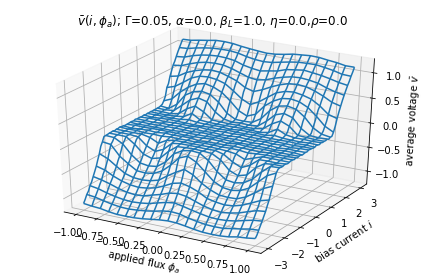

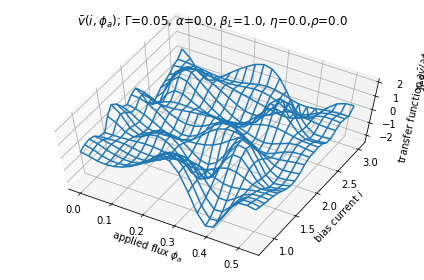

In [43]:
Vsurf = transfer_fn(nStep,tau,s,par,i,phia)

These simulations were getting very long, on the order of 30 minutes to an hour as I was trying to develop data sets dense enough, and averaged over a long enough time, to adequately investigate the nature of the surface in relatively fine detail.

In [44]:
%%time 
# cell magic timer to see how long this takes...
m = len(i)
n = len(phia)
l = int(nStep*0.05)
N = m*n
vp = np.zeros([n,m]) # average v at fixed phia
iv = np.zeros([m,n]) # average v at fixed i

for j in range(0,m):
    for k in range(0,n):
        par[4] = i[j]
        par[5] = phia[k]
        X = noisySQUID(nStep,tau,s,par)
        v = np.average(X[6,l:]) # average voltage
        vp[k,j] = v 
        iv[j,k] = v
        update_progress((j*n+k)/(m*n))
update_progress(1)

Progress: [####################] 100.0%
Wall time: 5min 57s


In [69]:
## write out or read in data files as desired

#np.savetxt("test.csv", vp, delimiter=",")
#np.savetxt("test.csv", iv, delimiter=",")
#vp = np.genfromtxt('vp.csv',delimiter=',')
#iv = np.array(np.genfromtxt('AveVsurface20191130002348.csv',delimiter=','))

In [ ]:
fig = plt.figure(figsize=[9,6])

ax1 = plt.subplot(1,2,1)
ax1.plot(phia,vp[:,0],label=round(i[0],2))
for h in range(1,len(vp[0,:])):
    ax1.plot(phia,vp[:,h],label=round(i[h],2))
ax1.set(title=r'$\bar{v}(i,\phi_a)$',
        xlabel=r'applied flux $\phi_a$',
        ylabel=r'average voltage $\bar{v}$')
ax1.legend(loc=6,title=r'$i$')

ax2 = plt.subplot(1,2,2)
ax2.plot(vp[0,:],i,label=round(phia[0],3))
for h in range(1,len(vp[:,0])):
    ax2.plot(vp[h,:],i,label=round(phia[h],3))
ax2.set(title=r'$i(\bar{v},\phi_a)$',
        xlabel=r'average voltage $\bar{v}$',
        ylabel=r'bias current $i$')
ax2.legend(title=r'$\phi_a$')
fig.tight_layout()
fig.savefig('test.jpg')

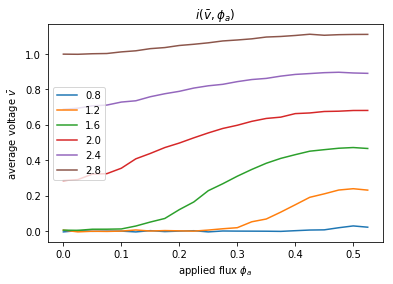

In [348]:
plt.plot(phia,vp[:,0],label=round(i[0],2))
plt.plot(phia,vp[:,4],label=round(i[4],2))
plt.plot(phia,vp[:,8],label=round(i[8],2))
plt.plot(phia,vp[:,12],label=round(i[12],2))
plt.plot(phia,vp[:,16],label=round(i[16],2))
plt.plot(phia,vp[:,20],label=round(i[20],2))
#for h in range(1,len(vp[0,:])):
    #plt.plot(phia,vp[:,h],label=round(i[h],2))
plt.title(r'$i(\bar{v},\phi_a)$')
plt.xlabel(r'applied flux $\phi_a$')
plt.ylabel(r'average voltage $\bar{v}$')
plt.legend(loc=6)

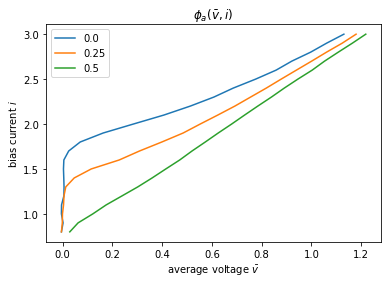

In [219]:
plt.plot(vp[0,:],i,label=round(phia[0],3))
plt.plot(vp[10,:],i,label=round(phia[10],3))
plt.plot(vp[20,:],i,label=round(phia[20],3))
#for h in range(1,len(vp[:,0])):
    #plt.plot(vp[h,:],i,label=round(phia[h],3))
plt.title(r'$\phi_a(\bar{v},i)$')
plt.xlabel(r'average voltage $\bar{v}$')
plt.ylabel(r'bias current $i$')
plt.legend()

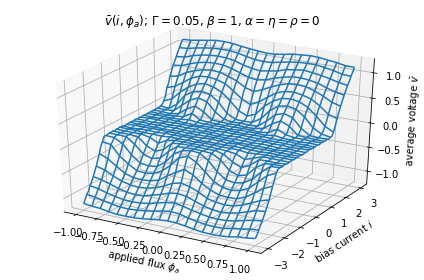

In [66]:
fig = plt.figure()
ax = fig.gca(projection='3d')
x = np.copy(i)
y = np.copy(phia)
x, y = np.meshgrid(y, x)
z = np.copy(Vsurf)
ax.plot_wireframe(x, y, z) # cmap='terrain'
# note the xlabel and ylabel are reversed, this is correct
ax.set(ylabel=r'bias current $i$',
       xlabel=r'applied flux $\phi_a$',
       zlabel=r'average voltage $\bar{v}$',
      title = r'$\bar{v}(i,\phi_a)$; $\Gamma=0.05$, $\beta=1$, $\alpha=\eta=\rho=0$')
fig.tight_layout()
fig.savefig('test.jpg')

In [64]:
## smooth and interpolate over a grid lx dense ##
l = 1.
inew = np.arange(-3.,3.1,0.1/l)#inew = np.arange(1,2.55,0.05/l)#inew = np.arange(0.8,3.1,0.1/l)
phianew = np.arange(-1.,1.1,.1/l)#phianew = np.arange(0.,.5,.03125/l)#phianew = np.arange(0.,.55,.025/l)

x, y = np.meshgrid(phia,i)
xnew, ynew = np.meshgrid(phianew,inew)
z = np.copy(Vsurf)
tck = interpolate.bisplrep(y, x, z, s=.05) # s = smoothing
ivi = interpolate.bisplev(ynew[:,0], xnew[0,:], tck)
ivi.shape

(61, 21)

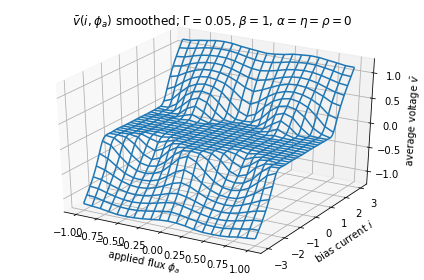

In [65]:
fig = plt.figure()
ax = fig.gca(projection='3d')
#x = np.copy(i)
#y = np.copy(phia)
#x, y = np.meshgrid(y, x)
#z = np.copy(ivi)
ax.plot_wireframe(xnew, ynew, ivi) # cmap='terrain'
# note the xlabel and ylabel are reversed, this is correct
ax.set(ylabel=r'bias current $i$',
       xlabel=r'applied flux $\phi_a$',
       zlabel=r'average voltage $\bar{v}$',
      title = r'$\bar{v}(i,\phi_a)$ smoothed; $\Gamma=0.05$, $\beta=1$, $\alpha=\eta=\rho=0$')
fig.tight_layout()
fig.savefig('test.jpg')

In [67]:
## Transfer function ##
# need partial dvbar/dphia as a function of i
# that is the transfer function

# first get derivative of surface vbar(i,phia)
# gradient() returns one surface of the value of the partial deriv
# for each dependent dimension. So two sets for us: dvbar/di and 
# dvbar/dphia. We are interested in the second here.


dv = np.gradient(ivi,inew,phianew) # bingo, dv[1] = dvbar(i,phia)/dphia
                     # dv[0] = dvbar(i,phia)/di

# Next we can peep the surface

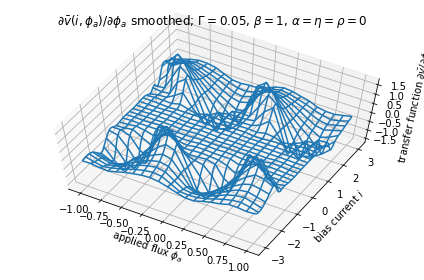

In [68]:
fig = plt.figure()
ax = fig.gca(projection='3d')
x = np.copy(inew)
y = np.copy(phianew)
x, y = np.meshgrid(y, x)
z = np.copy(dv[1]) # partial dvbar/dphia
ax.plot_wireframe(x, y, z) # cmap='terrain'
# note the xlabel and ylabel are reversed, this is correct
ax.set(ylabel=r'bias current $i$',
       xlabel=r'applied flux $\phi_a$',
       zlabel=r'transfer function $\partial\bar{v}/\partial\phi_a$',
      title = r'$\partial\bar{v}(i,\phi_a)/\partial\phi_a$ smoothed; $\Gamma=0.05$, $\beta=1$, $\alpha=\eta=\rho=0$')
ax.view_init(65,-60)
fig.tight_layout()
fig.savefig('test.jpg')

# This looks correct to me

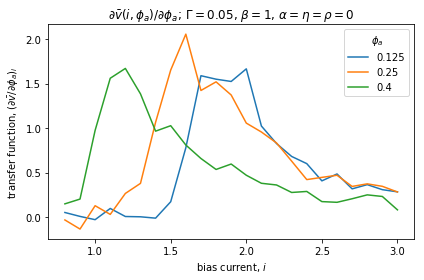

In [12]:
fig, ax = plt.subplots()
dv1 = np.copy(dv[1])
ax.plot(inew,dv1[:,int(5*l)],label=round(phianew[int(5*l)],3))
ax.plot(inew,dv1[:,int(10*l)],label=round(phianew[int(10*l)],3))
ax.plot(inew,dv1[:,int(-6*l)],label=round(phianew[int(-6*l)],3))
ax.set(title=r'$\partial \bar{v}(i,\phi_a)/\partial\phi_a$; $\Gamma=0.05$, $\beta=1$, $\alpha=\eta=\rho=0$',
      xlabel=r'bias current, $i$',
      ylabel=r'transfer function, $(\partial\bar{v}/\partial\phi_a)_i$')
ax.legend(title=r'$\phi_a$')
fig.tight_layout()